# Vectors
###### bcgov-rs-workshop-2023

In this notebook, we will look at ways to load, analyze, and display vectors using Python.

We'll start by installing a few additional modules to our environment that we'll use later. Custom environments do not persist between Google Colab sessions, so you will need to install these dependencies each time you start/restart the runtime.

In [4]:
!pip install geopandas pyproj mapclassify folium

^C


Import all the necessary dependencies.

In [5]:
import folium
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import requests

from pyproj import Transformer
from shapely.geometry import box, shape, Point, LineString, Polygon, MultiPolygon
from shapely.ops import transform

## Folium Maps

Google Colab environments contain the [folium](https://python-visualization.github.io/folium/) module by default, which provides methods for creating [leaflet](https://leafletjs.com/) maps within notebook environments.

To create a map, we initialize a map object, then render it by displaying its object representation.

In [6]:
m = folium.Map(location=[54, -123], zoom_start=6)
m

You can change the tiles source with the `tiles` keyword. There are several built-in options, listed below. You can also pass a url template string, pointing to other tile sources, like: `http://{s}.yourtiles.com/{z}/{x}/{y}.png`.

Try changing the tiles to different named source.

In [7]:
tiles = [
  "OpenStreetMap",
  "Stamen Terrain",
  "Stamen Toner",
  "Stamen Watercolor",
  "CartoDB positron",
  "CartoDB dark_matter"
]

m = folium.Map(location=[54, -123], zoom_start=6, tiles=tiles[5])
m

We'll make a function that is a little more compact for future calls when we want to make a new map. Try changing the map center or zoom level.

In [8]:
def make_map(lat=54, lng=-123, zoom=6):
  return folium.Map(location=[lat, lng], zoom_start=zoom)

make_map(zoom=10)

## Shapely

[Shapely](https://shapely.readthedocs.io/en/stable/) is a foundational module for planar vector data in Python. Shapely's data model includes:

- Points (`Point`)
- Curves (`LineString` and `LinearRing`)
- Surfaces (`Polygon`)
- Collections (`MultiPoint`, `MultiLineString`, and `MultiPolygon`)

Note that Shapely is not inherently *geospatial* - the user is responsible for managing coordinate reference systems.

Here, we create various types of Shapely geometry, and render them together using [Matplotlib pyplot](https://matplotlib.org/stable/api/pyplot_summary.html). You can also render individual Shapely objects by displaying the object representations.

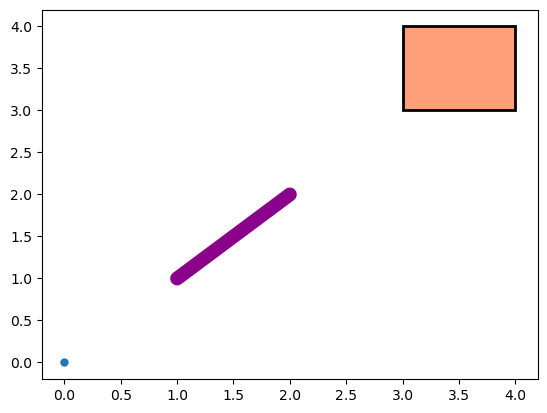

In [9]:
point = Point(0, 0)
linestring = LineString([(1, 1), (2, 2)])
polygon = Polygon(
    [(3, 3), (3, 4), (4, 4), (4, 3)]
)

plt.plot(*point.xy, markersize=5, marker='o')
plt.plot(*linestring.xy, color='darkmagenta', linewidth=10, solid_capstyle='round')
plt.fill(*polygon.exterior.xy, facecolor='lightsalmon', edgecolor="black", linewidth=2)

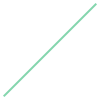

In [10]:
linestring # display the object representation

Let's work through a small exercise. The end goal is make a geographically constrained request to an API, and display the response data. We will define our constrained area by creating a point, buffering it, and constructing a bounding box around the buffered area. We will use the bounding box to constrain a request to the [BC Geographical Names Web Service](https://catalogue.data.gov.bc.ca/dataset/british-columbia-geographical-names-web-service-bcgnws) \([swagger doc](https://openapi.apps.gov.bc.ca/?url=https://raw.githubusercontent.com/bcgov/api-specs/master/bcgnws/bcgnws.json) ). Specifically, we will make a request to the [inside](https://openapi.apps.gov.bc.ca/?url=https://raw.githubusercontent.com/bcgov/api-specs/master/bcgnws/bcgnws.json#/search/get_names_inside) endpoint.

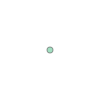

In [11]:
center_point = Point(-123, 54)
center_point

We can add [GeoJSON](https://geojson.org/) vector geometries to a folium map using the `GeoJson()` method, which will accept a Shapely geometry (among several other objects and file paths). 

In [12]:
m = make_map()
folium.GeoJson(center_point, name="Center").add_to(m)
m

Buffer the area. Here, we buffer using a value of `1`. Since Shapely does not consider coordinate reference systems, we can assume this represents 1 degree. We will explore whether this is desirable. Note that the buffered geometry appears circular when plotted on its own, in unitless space.

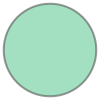

In [13]:
center_buffer = center_point.buffer(1)
center_buffer

However, the buffered geometry appears quite oblong when plotted on a web map. Even though our geometry is lat/long (EPSG:4326), the coordinate reference system on this web map (and almost any web map) is EPSG:3857 (Google Pseudo-Mercator). Folium converts all geometries from 4326 to 3857 on-the-fly. While this coordinate reference system has its geographical quirks, the main point is that it is projected, meaning that it uses projected coordinates (metres), so degrees (angles) do not map proportionally (in the map, latitude degrees are larger than longitude degrees).

Interestingly, if you use the provided coordinates and buffer values, you may notice that land use boundaries align to our projected lat/long geometry, because surveyors use lat/long coordinates. 

In [14]:
m = make_map()
folium.GeoJson(center_buffer, name="Center Buffer").add_to(m)
m

If we want to create a circular buffer, we can project our original point geometry to a projected coordinate reference system, and buffer that instead. Here, we use a `pyproj.Transformer()` to project from the lat/long coordinate space (EPSG:4326) to a projection (EPSG:9822 - Albers Equal Area).

In [15]:
transformer = Transformer.from_crs(4326, 9822, always_xy=True)
proj_center_point = Point(transformer.transform(center_point.x, center_point.y))

proj_center_point.xy

(array('d', [-4020636.3263634825]), array('d', [7723772.8863927135]))

Buffer by a value. Again, Shapely does not consider coordinate reference system, so the values are technically unitless. We know that we are interpreting the values in the units of the projection (metres), though. So, in this case, we can imagine that we are buffering by 100,000m (100km). The geometry appears circular when plotted by itself.

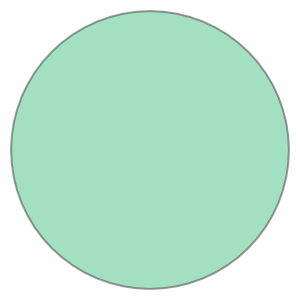

In [16]:
proj_center_buffer = proj_center_point.buffer(100000)
proj_center_buffer

If we want to display the geometry on a `folium` map, we must transform the geometry back to lat/long coordinates. Notice that our circular geometry (again, a unitless Shapely geometry) now appears oblong, because the projected coordinates have been mapped to lat/long coordinates but displayed in unitless space.

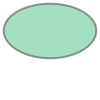

In [17]:
project = Transformer.from_proj(9822, 4326, always_xy=True)

proj_center_buffer_circle = transform(project.transform, proj_center_buffer)
proj_center_buffer_circle

When we plot the geometry on a `folium` map, though, the geometry is displayed in a nice circular shape.

In [18]:
m = make_map()
folium.GeoJson(proj_center_buffer_circle, name="Center Buffer (projected)").add_to(m)
m

Ultimately, we want the bounding box coordinates to send in a request to geographically constrain the response. Each Shapely geometry has a `bounds` property that returns a tuple of bounding coordinates, in (east, south, west, north) order.

In [19]:
proj_center_buffer_circle.bounds

(-124.4892788754053, 53.12089502161035, -121.51077726703305, 54.87578558042881)

We can also create a Shapely geometry from bounding box coordinates. Here, we use "variable unpacking" notation (`*`), which means, "expand and use all the values within this variable", so rather than specifying each of the four required parameters, we can simply unpack them.

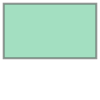

In [20]:
proj_center_buffer_circle_bbox = box(*proj_center_buffer_circle.bounds)
proj_center_buffer_circle_bbox

The API accepts bounding coordinates as a comma-delimited `string`. Here, we use a list comprehension to concisely turn our four numerical bounding coordinates into a comma-delimited string:

In [21]:
bounds_str = ",".join([str(i) for i in proj_center_buffer_circle.bounds])
bounds_str

'-124.4892788754053,53.12089502161035,-121.51077726703305,54.87578558042881'

We can make a request to the API ([swagger](https://openapi.apps.gov.bc.ca/?url=https://raw.githubusercontent.com/bcgov/api-specs/master/bcgnws/bcgnws.json#/search/get_names_inside)) like below. The `requests` module includes a `params` argument that will format a Python dictionary into url parameters.

So, given a dictionary like: `{"a":1, "b":2}`

requests will be transformed to use url parameters like: `?a=1&b=2`

The following sends a request to to the BC Geonames API `/inside` endpoint, specifying that we want:
- a json (or geojson) response
- within the bounding box coordinates
- sorted by the `name` field
- in lat/long coordinates (4326)
- in a bespoke summary style
- with maximum 200 returned items per "page" of results
- starting with page 1 of results

In [22]:
url = "https://apps.gov.bc.ca/pub/bcgnws/names/inside"

payload = {
    "outputFormat": "json",
    "bbox": bounds_str,
    "sortBy": "name",
    "outputSRS": 4326,
    "outputStyle": "summary",
    "itemsPerPage": 200,
    "startIndex": 1
}

headers = {}

response = requests.request("GET", url, headers=headers, params=payload)

response_json = response.json()
response_json

{'type': 'FeatureCollection',
 'properties': {'service': 'apps.gov.bc.ca/pub/bcgnws/names/inside',
  'totalResults': 1332,
  'startIndex': 1,
  'itemsPerPage': 200},
 'crs': {'type': 'name', 'properties': {'name': 'EPSG:4326'}},
 'features': [{'type': 'Feature',
   'properties': {'uri': 'apps.gov.bc.ca/pub/bcgnws/names/38985',
    'name': '28 Mile Lake',
    'language': 'not defined',
    'status': 'adopted',
    'isOfficial': 1,
    'nameAuthority': {'resourceUrl': 'apps.gov.bc.ca/pub/bcgnws/nameAuthorities/1',
     'id': '1',
     'nameAuthority': 'BC Geographical Names Office',
     'webSiteUrl': 'http://www2.gov.bc.ca/gov/content/governments/celebrating-british-columbia/historic-places/geographical-names'},
    'tags': [],
    'score': 1.0,
    'feature': {'id': '38080',
     'uuid': '0caa20a8849c20c3e3a42799afb51e47',
     'uri': 'apps.gov.bc.ca/pub/bcgnws/features/38080',
     'mapsheets': 'apps.gov.bc.ca/pub/bcgnws/features/38080/mapsheets',
     'names': 'apps.gov.bc.ca/pub/bcg

We can then display the results on a `folium` map. The following cell does a few interesting things:
- create a map object
- set up a template popup, indicating that it will display the `name` field from the data
- create a layer from the geonames response data (point geometries), with a layer name and popup, and add it to the map
- create a layer from the bounding box geometry, with a layer name, and add it to the map
- add a layer control to the map, which will be populated with named layers
- display the map

Click on any of the geoname points to see the popup. Inspect the layer control (top-right of map) and see that you can toggle layer visibility.

In [23]:
m = make_map()
popup = folium.GeoJsonPopup(fields=["name"])
folium.GeoJson(response_json, name="BC Place Names", popup=popup).add_to(m)
folium.GeoJson(proj_center_buffer_circle_bbox, name="Bounding Box").add_to(m)
folium.map.LayerControl().add_to(m)
m

We will conclude this chapter on Shapely by inspecting a few set operations. Each example uses `center_buffer` and `proj_center_buffer_circle`, created above. Try switching which geometry acts on the other to see any differences.

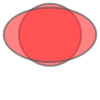

In [24]:
combined_geoms = MultiPolygon([center_buffer, proj_center_buffer_circle])
combined_geoms

Difference:

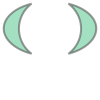

In [25]:
difference = proj_center_buffer_circle.difference(center_buffer)
difference

Intersection:

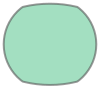

In [26]:
intersection = proj_center_buffer_circle.intersection(center_buffer)
intersection

Symmetric Difference:

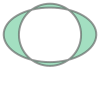

In [27]:
symmetric_difference = proj_center_buffer_circle.symmetric_difference(center_buffer)
symmetric_difference

Union:

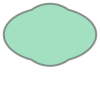

In [28]:
union = proj_center_buffer_circle.union(center_buffer)
union

## GeoPandas

As you've seen, Shapely provides very granular access to vector data, which can be useful when needed, but time consuming when not.

[GeoPandas](https://geopandas.org/en/stable/) is a higher level module, providing access to vector data in a more hands-off way. GeoPandas is built upon [pandas](https://pandas.pydata.org/docs/index.html#), a popular general purpose data analysis tool.

pandas provides two main data structures:
- Series: a 1-dimensional labeled array containing one of several data types (e.g. integer, string, date, etc.)
- DataFrame: a 2-dimensional labeled structure containing zero or more series

Series are like columns. DataFrames are like tables.

GeoPandas extends pandas by introducing geometric data types (Shapely objects) and geospatial properties (e.g. bounds, area, etc.) and methods (e.g. plot a map).

The first step is generally to load some data into a [GeoDataFrame](https://geopandas.org/en/stable/docs/user_guide/data_structures.html#geodataframe) (gdf). Here, we load the previous API response into a string which can be read like a file, but you could similarly load various files from disk. The `info()` method lists series and data types. Note that there is a `geometry` type column.

In [29]:
gdf = gpd.read_file(json.dumps(response_json), driver='GeoJSON')
gdf.head() # print first few records

,uri,name,language,status,isOfficial,nameAuthority,tags,score,feature,changeDate,...,featureCategory,featureCategoryDescription,featureCategoryURI,featureType,lonAsRecorded,latAsRecorded,datumAsRecorded,position,ntsMap,geometry
0,apps.gov.bc.ca/pub/bcgnws/names/38985,28 Mile Lake,not defined,adopted,1,{'resourceUrl': 'apps.gov.bc.ca/pub/bcgnws/nam...,[ ],1.0,"{'id': '38080', 'uuid': '0caa20a8849c20c3e3a42...",2012-03-05,...,10,Standing Water Surrounded by Land,apps.gov.bc.ca/pub/bcgnws/featureCategories/10,Lake,1241059,544709,WGS84,CENTRE,93K/16,POINT (-124.18333 54.78611)
1,apps.gov.bc.ca/pub/bcgnws/names/165,Aba Lake,not defined,adopted,1,{'resourceUrl': 'apps.gov.bc.ca/pub/bcgnws/nam...,[ ],1.0,"{'id': '8817', 'uuid': '0c8a3a6f849c20c33a4a3e...",2012-03-05,...,10,Standing Water Surrounded by Land,apps.gov.bc.ca/pub/bcgnws/featureCategories/10,Lake,1220448,532836,WGS84,CENTRE,93G/8,POINT (-122.08000 53.47694)
2,apps.gov.bc.ca/pub/bcgnws/names/118,Mount Abbl,not defined,adopted,1,{'resourceUrl': 'apps.gov.bc.ca/pub/bcgnws/nam...,"[ { ""tag_id"": 2, ""tag_name"": ""World War II"" } ]",1.0,"{'id': '8776', 'uuid': '0c8a302c849c20c394e422...",2011-10-04,...,15,Elevated,apps.gov.bc.ca/pub/bcgnws/featureCategories/15,Mount,1214232,544101,WGS84,CENTRE,93I/12,POINT (-121.70917 54.68389)
3,apps.gov.bc.ca/pub/bcgnws/names/38986,Adam Lake,not defined,adopted,1,{'resourceUrl': 'apps.gov.bc.ca/pub/bcgnws/nam...,[ ],1.0,"{'id': '38081', 'uuid': '0caa20ea849c20c3bcc92...",2012-03-05,...,10,Standing Water Surrounded by Land,apps.gov.bc.ca/pub/bcgnws/featureCategories/10,Lake,1224505,542112,WGS84,CENTRE,93J/7,POINT (-122.75167 54.35361)
4,apps.gov.bc.ca/pub/bcgnws/names/341,Adrian Lake,not defined,adopted,1,{'resourceUrl': 'apps.gov.bc.ca/pub/bcgnws/nam...,[ ],1.0,"{'id': '8983', 'uuid': '0c8a728b849c20c3019c8c...",2012-03-05,...,10,Standing Water Surrounded by Land,apps.gov.bc.ca/pub/bcgnws/featureCategories/10,Lake,1225917,542948,WGS84,CENTRE,93J/7,POINT (-122.98833 54.49694)


In [30]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   uri                         200 non-null    object  
 1   name                        200 non-null    object  
 2   language                    200 non-null    object  
 3   status                      200 non-null    object  
 4   isOfficial                  200 non-null    int64   
 5   nameAuthority               187 non-null    object  
 6   tags                        200 non-null    object  
 7   score                       200 non-null    float64 
 8   feature                     200 non-null    object  
 9   changeDate                  200 non-null    object  
 10  decisionDate                196 non-null    object  
 11  featureCategory             200 non-null    int64   
 12  featureCategoryDescription  200 non-null    object  
 13  featureCateg

We can inspect the geometry type:

In [31]:
gdf.geom_type

0      Point
1      Point
2      Point
3      Point
4      Point
       ...  
195    Point
196    Point
197    Point
198    Point
199    Point
Length: 200, dtype: object

Inspect the coordinate reference system:

In [32]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We can map a data frame or series with the `explore()` method. In fact, it creates a familiar `folium` map. Hover over any of the geometries, and notice that it also creates popups for us:

In [33]:
gdf.explore()

We can also plot nonspatial (or spatial) data. Notice that xy positions are derived from the geometry column (the default `kind` of chart is `geo`), and we can specify other chart parameters. In this case, we color the points by two existing columns, which happen to be `latAsRecorded` and `lonAsRecorded`. See if you can find other columns to chart, other chart types, other colormaps, etc.:

(<Axes: >, <Axes: >)

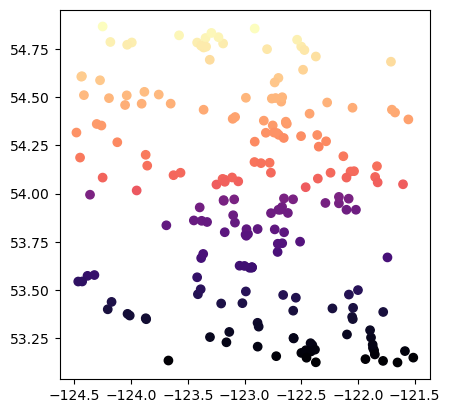

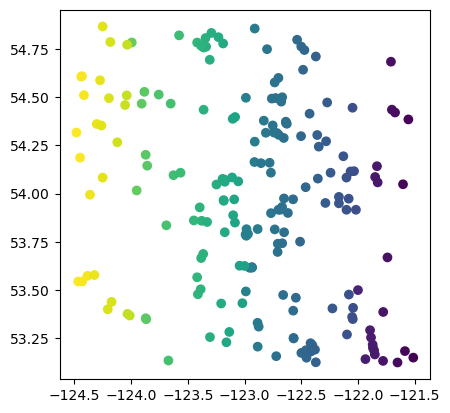

In [34]:
gdf.plot(column="latAsRecorded", cmap="magma"), gdf.plot(column="lonAsRecorded", cmap="viridis")

We can apply a buffer to the data frame with the `buffer` method. As we saw previously, the data frame has a lat/long (4326) coordinate reference system, which means that the buffer method will use units of degrees. Also, note that we can chain methods together: first buffer, then display map.

In [35]:
gdf.buffer(0.1).explore()

C:\Users\Matt\AppData\Local\Temp\ipykernel_9732\4103335823.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.buffer(0.1).explore()


We can also quickly reproject geometries. Here, we reproject to Albers Equal Area projection, buffer by 10000 units (metres), then display a map.

In [ ]:
gdf.to_crs(9822).buffer(10000).explore()

Finally, we can filter data in the data frame on the fly. When we use syntax like `gdf[]` it can mean two things:
- return a subset of series in the data frame. In this example, we use `gdf["name"]` to select only the `name` series. The full chain is `gdf["name"].str.startswith("B")` meaning: for each item in the `name` series, return true or false whether the string starts with the letter "B". 
- return the data frame items where the clause inside the brackets is true. In this case, the clause is `gdf["name"].str.startswith("B")` (which returns a series of true/false values). The full statement `gdf[gdf["name"].str.startswith("B")]` returns a GeoSeries of Shapely objects, where the name value starts with the letter "B".

In [36]:
gdf[gdf["name"].str.startswith("B")].explore(tiles="CartoDB dark_matter")

## Extra Credit Ideas

- explore [geojson.io](https://geojson.io/):
  - try creating some geojson geometries
  - save the geojson file
  - upload the geojson to this notebook's files
  - load and display the geojson on a folium map
- find a shapefile (e.g. in the [BC Data Catalogue](https://www2.gov.bc.ca/gov/content/data/bc-data-catalogue))
  - upload the shapefile (all parts) to this notebook's files
  - use GeoPandas `read_file()` to load the data to a GeoDataFrame
  - display on a folium map
- try running through the GeoPandas [Overlay Countries Example](https://geopandas.org/en/stable/docs/user_guide/set_operations.html#overlay-countries-example)
- [Leafmap](https://leafmap.org/) is plotting/analysis module that we will not have time to cover in this workshop, but it is worth looking into.
  - [install](https://leafmap.org/installation/) leafmap
  - work through the [getting started](https://leafmap.org/get-started/)
- we briefly used [Matplotlib](https://matplotlib.org/) in this notebook, but it is worth your time learning more about it, as many modules build upon it. Look through the [gallery](https://matplotlib.org/stable/gallery/index) to see the wide variety of available plotting styles, and try making your own plots.
- [HoloViews](https://holoviews.org/) is another popular plotting library, especially useful for creating interactive charts within notebooks. Look through the [gallery](https://holoviews.org/gallery/index.html) for inspiration.